In [1]:
import json
import pathlib

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
!mkdir -p img

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "figure.figsize": (3, 2.5),
        "figure.dpi": 140,
    }
)

In [3]:
def load_benchmark_data(file_name=None, columns=None):
    if file_name is None:
        file_name = pathlib.Path().resolve().parent / "benchmark.json"

    if columns is None:
        columns = dict()
        for key in [
            "vanilla-N",
            "vanilla-P",
            "linear-N",
            "linear-P",
            "simd-N",
            "simd-P",
        ]:
            columns[key] = ["N", "P", "p", "t"]

        for key in [
            "cuda-N",
            "cuda-P",
            "kernel_size",
        ]:
            columns[key] = ["N", "P", "p", "grid_size", "block_size", "t"]

    assert file_name.is_file(), file_name
    data = json.load(open(file_name, "r"))["benchmarks"]
    data = {entry["name"]: entry["real_time"] / 1e9 for entry in data}

    df = {key.split("/")[0]: [] for key in data.keys()}
    assert all(key in df for key in columns), (df.keys(), columns.keys())

    for key in df:
        values = [
            list(map(int, col[1:])) + [data[column]]
            for column in data
            if (col := column.split("/"))[0] == key
        ]
        df[key] = pd.DataFrame(values, columns=columns[key])
        if "p" in df[key].columns:
            df[key]["p"] /= 100
            df[key]["pP"] = df[key]["p"] * df[key]["P"]

    return df


DATA = load_benchmark_data()
DATA.keys()

dict_keys(['kernel_size', 'vanilla-P', 'linear-P', 'simd-P', 'cuda-P', 'vanilla-N', 'linear-N', 'simd-N', 'cuda-N'])

In [4]:
def plot_absperf(data, var, *, normalize=None):
    assert var in ["pP", "N"]

    if normalize is None:
        normalize = var == "pP"

    fig, ax = plt.subplots(constrained_layout=True)

    kwargs = {
        "vanilla": {"color": "k", "label": "Vanilla", "marker": ".", "alpha": 0.7},
        "linear": {"color": "C1", "label": "Linear", "marker": "s", "alpha": 0.5},
        "simd": {"color": "C3", "label": "SIMD", "marker": "D", "alpha": 0.5},
        "cuda": {"color": "C2", "label": "CUDA", "marker": "o", "alpha": 0.5},
    }

    for key in ["vanilla", "linear", "simd", "cuda"]:
        values = data[key + "-" + var[-1]]

        t = values["t"]
        ax.plot(values[var], t / values["N"] if normalize else t, "--", **kwargs[key])

    if var == "pP":
        ax.set_xlabel(
            "$P$"
            if all([np.all(np.isclose(data[k]["p"], 1.0)) for k in data])
            else r"$\langle P \rangle$"
        )
    elif var == "N":
        ax.set_xlabel("$N$")

    ax.set_ylabel(r"Time / $N$ (s)" if normalize else "Time (s)")
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")

    ax.grid()

    ax.legend()

    fig.savefig(f"img/abs_performance-{var}.png")

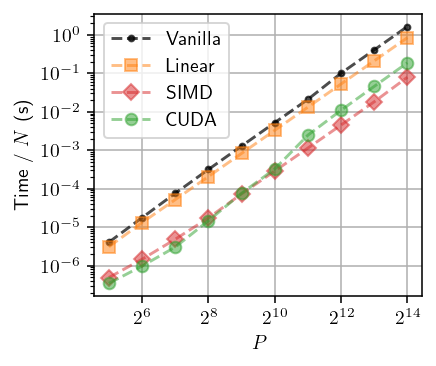

In [5]:
plot_absperf(DATA, "pP")

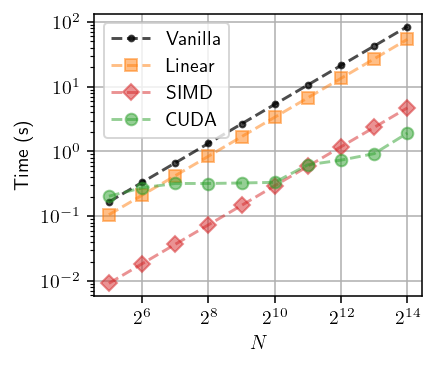

In [6]:
plot_absperf(DATA, "N")

In [7]:
def plot_relperf(data, var):
    assert var in ["pP", "N"]

    fig, ax = plt.subplots(constrained_layout=True)

    kwargs = {
        "vanilla": {"color": "k", "label": "Vanilla", "marker": ".", "alpha": 0.7},
        "linear": {"color": "C1", "label": "Linear", "marker": "s", "alpha": 0.5},
        "simd": {"color": "C3", "label": "SIMD", "marker": "D", "alpha": 0.5},
        "cuda": {"color": "C2", "label": "CUDA", "marker": "o", "alpha": 0.5},
    }

    ref = data["vanilla-" + var[-1]]

    for key in ["vanilla", "linear", "simd", "cuda"]:
        values = data[key + "-" + var[-1]]
        y = ref["t"] / values["t"]
        ax.plot(values[var], y, "--", **kwargs[key])

    if var == "pP":
        ax.set_xlabel(
            "$P$"
            if all([np.all(np.isclose(data[k]["p"], 1.0)) for k in data])
            else r"$\langle P \rangle$"
        )
    elif var == "N":
        ax.set_xlabel("$N$")

    ax.set_ylabel("Rel. improvement")
    ax.set_xscale("log", base=2)

    ax.legend()

    fig.savefig(f"img/rel_performance-{var}.png")

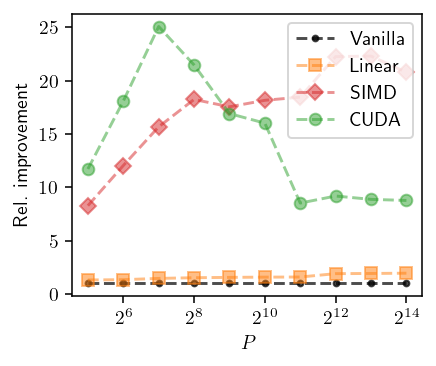

In [8]:
plot_relperf(DATA, "pP")

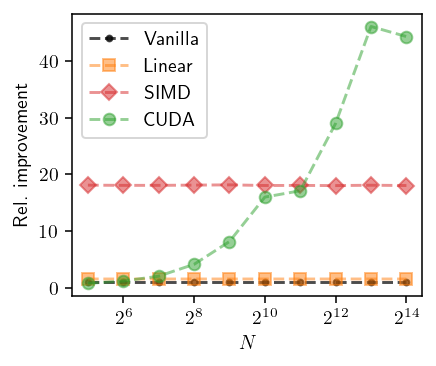

In [9]:
plot_relperf(DATA, "N")